# Sample code for log-likelihood calibration


## About this document

This document was generated from an R markdown file on `r as.character(Sys.time())`. It illustrates how to set up a calibration with a log-likelihood objective.

## Setting up a calibration on daily data

We will use some sample data from (MMH) included in the package

In [1]:
from swift2.parameteriser import concatenate_parameterisers, create_parameteriser, extract_optimisation_log, parameteriser_as_dataframe, sort_by_score
from swift2.simulation import create_subarea
from swift2.utils import c, mk_full_data_id, paste0
from swift2.parameteriser import create_parameteriser, create_parameter_sampler, create_sce_termination_wila, get_default_sce_parameters
from swift2.doc_helper import get_free_params, sample_series, set_loglik_param_keys
import pandas as pd
import numpy as np
from swift2.vis import OptimisationPlots
import xarray as xr

In [2]:
from cinterop.timeseries import as_timestamp
s = as_timestamp('1990-01-01')
e = as_timestamp('2005-12-31')

rain = sample_series('MMH', 'rain')[slice(s, e)]
evap = sample_series('MMH', 'evap')[slice(s, e)]
flow = sample_series('MMH', 'flow')[slice(s, e)]

In [3]:
rain.describe()

count    5844.000000
mean        3.545405
std         7.737554
min         0.000000
25%         0.000000
50%         0.283600
75%         3.308775
max        97.645500
dtype: float64

In [4]:
flow.describe()

count    5844.000000
mean       -1.993059
std        16.361702
min       -99.999000
25%         0.194400
50%         0.438400
75%         0.900200
max        17.221100
dtype: float64

We need to adjust the observed flow, as the SWIFTv1 legacy missing value code is `-99`. 

In [5]:
flow[flow < 0] = np.nan

In [6]:
flow

1990-01-01    0.2577
1990-01-02    0.2459
1990-01-03    0.2374
1990-01-04    0.2218
1990-01-05    0.2127
               ...  
2005-12-27    0.3477
2005-12-28    0.3314
2005-12-29    0.3333
2005-12-30    0.3066
2005-12-31    0.2896
Length: 5844, dtype: float64

## Catchment setup

Let's create a single catchment setup, using daily data. We need to specify the simulation time step to be consistent with the daily input data.

In [7]:
ms = create_subarea('GR4J', 1.0)
from cinterop.timeseries import xr_ts_start, xr_ts_end
s = xr_ts_start(rain)
e = xr_ts_end(rain)
ms.set_simulation_span(s, e)
ms.set_simulation_time_step('daily')

Assign input time series

In [8]:
sa_name = ms.get_subarea_names()[0]
ms.play_subarea_input(rain, sa_name, "P")
ms.play_subarea_input(evap, sa_name, "E")

Model variables identifiers are hierarchical, with separators '.' and '|' supported. The "dot" notation should now be preferred, as some R functions producing data frames may change the variable names and replace some characters with '.'.

In [9]:
sa_id = paste0("subarea.", sa_name)
root_id = paste0(sa_id, ".")
print(ms.get_variable_ids(sa_id))

['subarea.Subarea.areaKm2', 'subarea.Subarea.P', 'subarea.Subarea.E', 'subarea.Subarea.En', 'subarea.Subarea.LAI', 'subarea.Subarea.runoff', 'subarea.Subarea.S', 'subarea.Subarea.R', 'subarea.Subarea.TWS', 'subarea.Subarea.Eactual', 'subarea.Subarea.Ps', 'subarea.Subarea.Es', 'subarea.Subarea.Pr', 'subarea.Subarea.ech1', 'subarea.Subarea.ech2', 'subarea.Subarea.Perc', 'subarea.Subarea.alpha', 'subarea.Subarea.k', 'subarea.Subarea.x1', 'subarea.Subarea.x2', 'subarea.Subarea.x3', 'subarea.Subarea.x4', 'subarea.Subarea.UHExponent', 'subarea.Subarea.PercFactor', 'subarea.Subarea.OutflowVolume', 'subarea.Subarea.OutflowRate']


In [10]:
gr4_state_names = paste0(root_id, c('runoff', 'S', 'R', 'Perc'))
for name in gr4_state_names: 
    ms.record_state(name)

Let's check that one simulation runs fine, before we build a calibration definition.

In [11]:
ms.exec_simulation()
sState = ms.get_recorded(gr4_state_names[2])

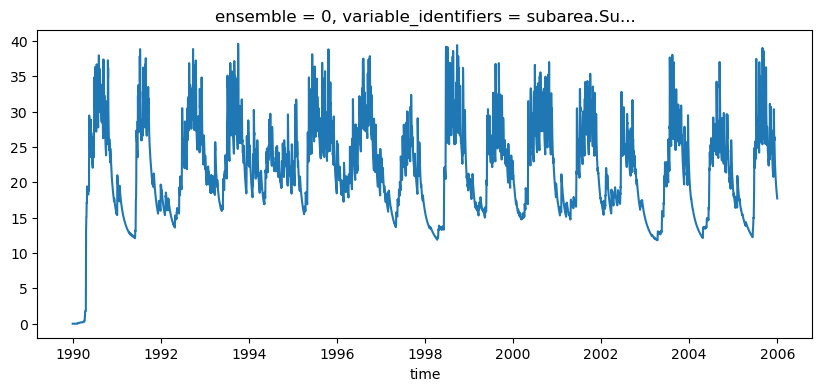

In [12]:
sState.plot(figsize=(10,4))

Let's build the objective calculator that will guide the calibration process:

In [13]:
w = pd.Timestamp("1992-01-01")

In [14]:
runoff_depth_varname = 'subarea.Subarea.runoff'
mod_runoff = ms.get_recorded(runoff_depth_varname)
# zoo::index(flow) = zoo::index(mod_runoff)
objective = ms.create_objective(runoff_depth_varname, flow, 'log-likelihood', w, e)

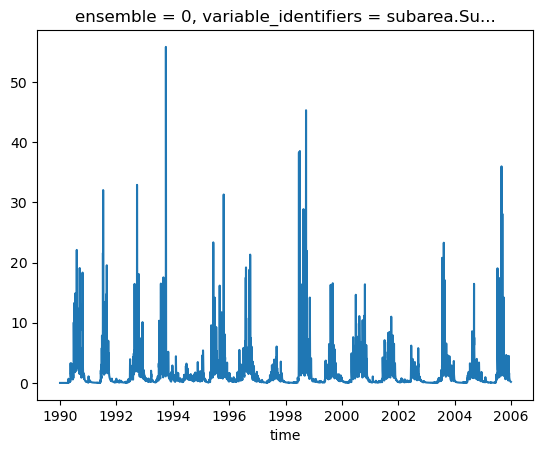

In [15]:
mod_runoff.plot()

## Parameterisation

Define the feasible parameter space, using a generic parameter set for the model parameters. This is 'wrapped' by a log-likelihood parameter set with the extra parameters used in the log likelihood calculation, but which exposes all the parameters as 8 independent degrees of freedom to the optimiser.

In [16]:
pspec_gr4j = get_free_params('GR4J')
pspec_gr4j.Value = c(542.1981111, -0.4127542, 7.7403390, 1.2388548)
pspec_gr4j.Min = c(1,-30, 1,1)
pspec_gr4j.Max = c(3000, 30, 1000, 240)
pspec_gr4j.Name = paste0(root_id, pspec_gr4j.Name)


maxobs = np.max(flow)
p = create_parameteriser(type='Generic', specs=pspec_gr4j)
set_loglik_param_keys(a='a', b='b', m='m', s='s', ct="ct", censopt='censopt')
censor_threshold = maxobs / 100 # TBC
censopt = 0.0

loglik = create_parameteriser(type='no apply')
loglik.add_to_hypercube( 
          pd.DataFrame({ 
          "Name": c('b','m','s','a','maxobs','ct', 'censopt'),
          "Min": c(-30, 0, -10,    -20, maxobs, censor_threshold, censopt),
          "Max":  c(5,   0, 10, 0, maxobs, censor_threshold, censopt),
          "Value": c(-7,  0, 0,  -10, maxobs, censor_threshold, censopt),
          }
          ) )
p = concatenate_parameterisers(p, loglik)
p.as_dataframe()

,Name,Value,Min,Max
0,subarea.Subarea.x1,542.198111,1.000000,3000.000000
1,subarea.Subarea.x2,-0.412754,-30.000000,30.000000
2,subarea.Subarea.x3,7.740339,1.000000,1000.000000
3,subarea.Subarea.x4,1.238855,1.000000,240.000000
4,b,-7.000000,-30.000000,5.000000
5,m,0.000000,0.000000,0.000000
6,s,0.000000,-10.000000,10.000000
7,a,-10.000000,-20.000000,0.000000
8,maxobs,17.221100,17.221100,17.221100
9,ct,0.172211,0.172211,0.172211


Check that the objective calculator works, at least with the default values in the feasible parameter space:

In [17]:
score = objective.get_score(p)
print(score)

{'scores': {'Log-likelihood': -1e+20}, 'sysconfig':                   Name       Value        Min          Max
0   subarea.Subarea.x1  542.198111   1.000000  3000.000000
1   subarea.Subarea.x2   -0.412754 -30.000000    30.000000
2   subarea.Subarea.x3    7.740339   1.000000  1000.000000
3   subarea.Subarea.x4    1.238855   1.000000   240.000000
4                    b   -7.000000 -30.000000     5.000000
5                    m    0.000000   0.000000     0.000000
6                    s    0.000000 -10.000000    10.000000
7                    a  -10.000000 -20.000000     0.000000
8               maxobs   17.221100  17.221100    17.221100
9                   ct    0.172211   0.172211     0.172211
10             censopt    0.000000   0.000000     0.000000}


In [18]:
mod_runoff = ms.get_recorded(runoff_depth_varname)

In [19]:
from swift2.vis import plot_two_series

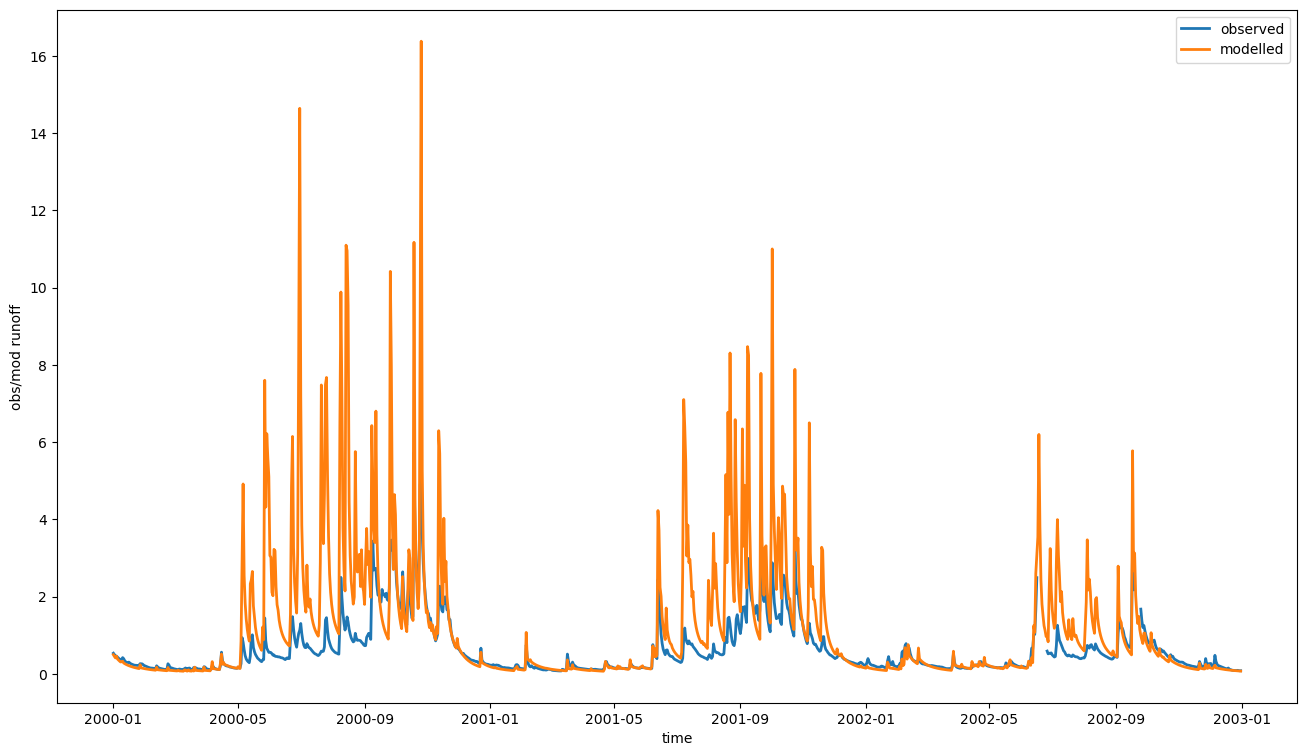

In [20]:
plot_two_series(flow, mod_runoff, ylab="obs/mod runoff", start_time = "2000-01-01", end_time = "2002-12-31", names=['observed','modelled'])

## Calibration

Build the optimiser definition, instrument with a logger.

In [21]:
# term = getMaxRuntimeTermination(max_hours = 0.3/60)  # ~20 second appears enough with SWIFT binaries in Release mode
# term = getMarginalTermination(tolerance = 1e-06, cutoff_no_improvement = 10, max_hours = 0.3/60) 
term = create_sce_termination_wila('relative standard deviation', c('0.005',str(1/60)))

sce_params = get_default_sce_parameters()
urs = create_parameter_sampler(0, p, 'urs')
optimiser = objective.create_sce_optim_swift(term, sce_params, urs)
calib_logger = optimiser.set_calibration_logger('')

In [22]:
%%time 
calib_results = optimiser.execute_optimisation()

CPU times: user 1min 33s, sys: 89.4 ms, total: 1min 33s
Wall time: 19.1 s


In [23]:
opt_log = extract_optimisation_log(optimiser, fitness_name = 'Log-likelihood')
geom_ops = opt_log.subset_by_message(pattern= 'Initial.*|Reflec.*|Contrac.*|Add.*') 

In [24]:
import matplotlib.pyplot as plt

In [25]:
ll_max = max(geom_ops._data['Log-likelihood'].values)
ll_min = np.median(geom_ops._data['Log-likelihood'].values)

## Parameter plots

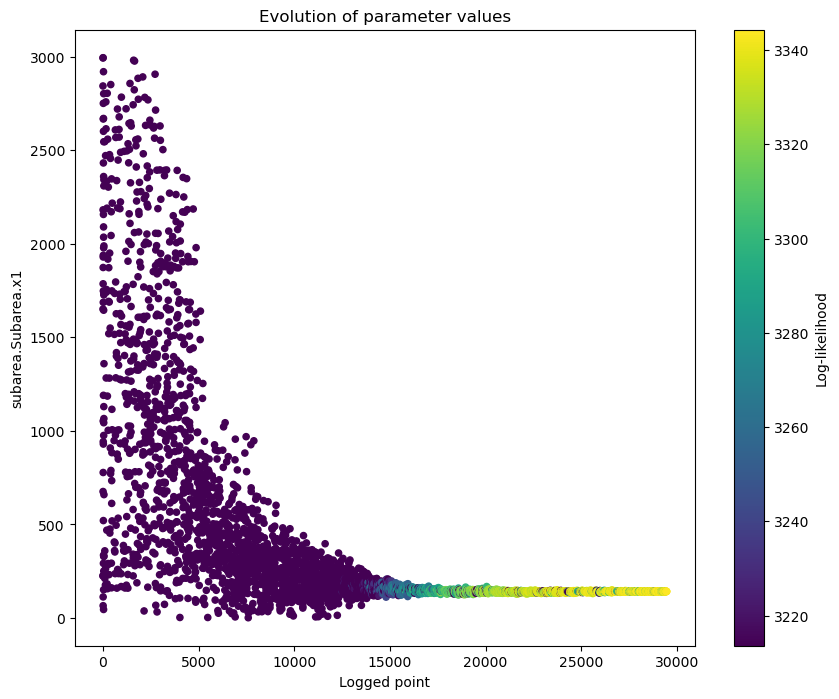

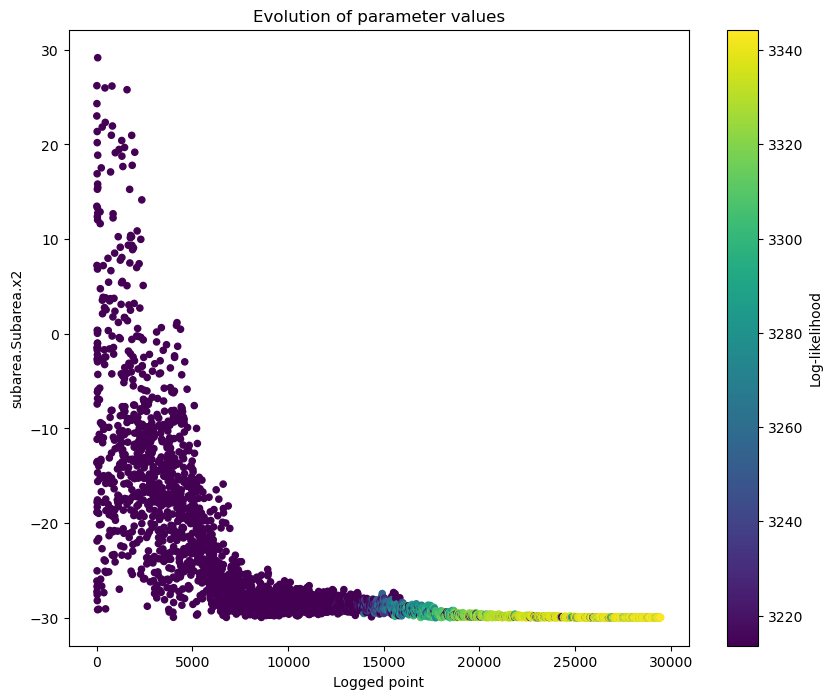

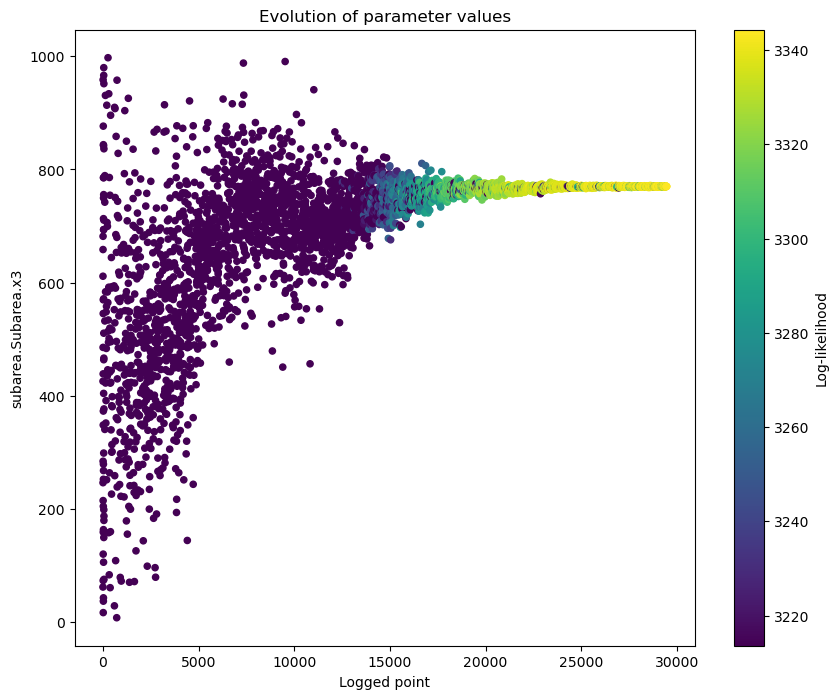

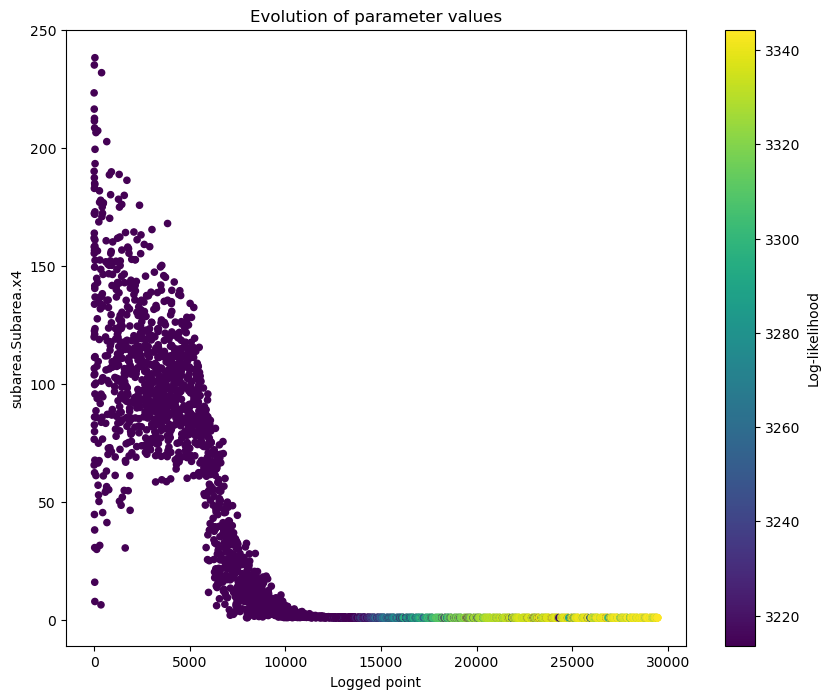

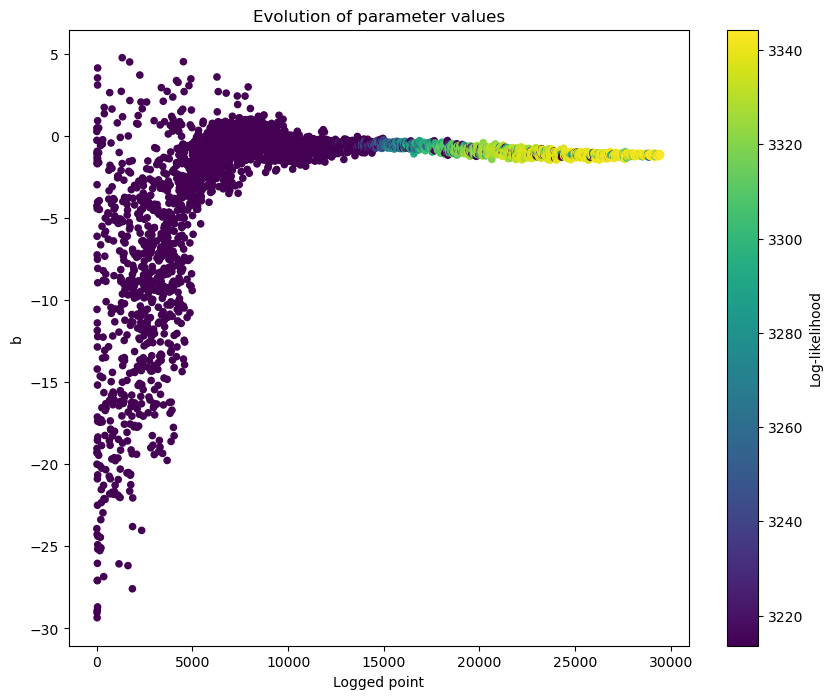

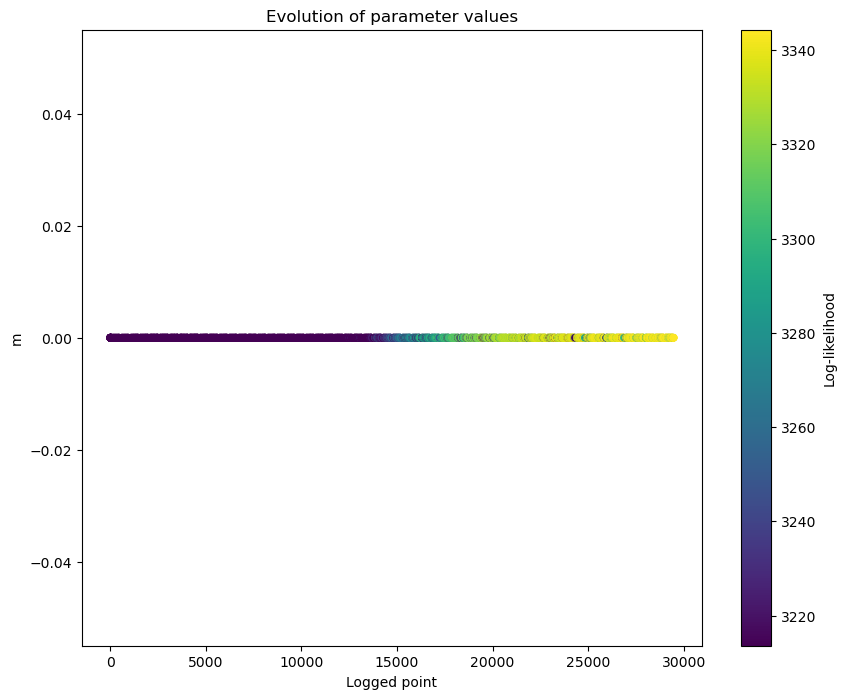

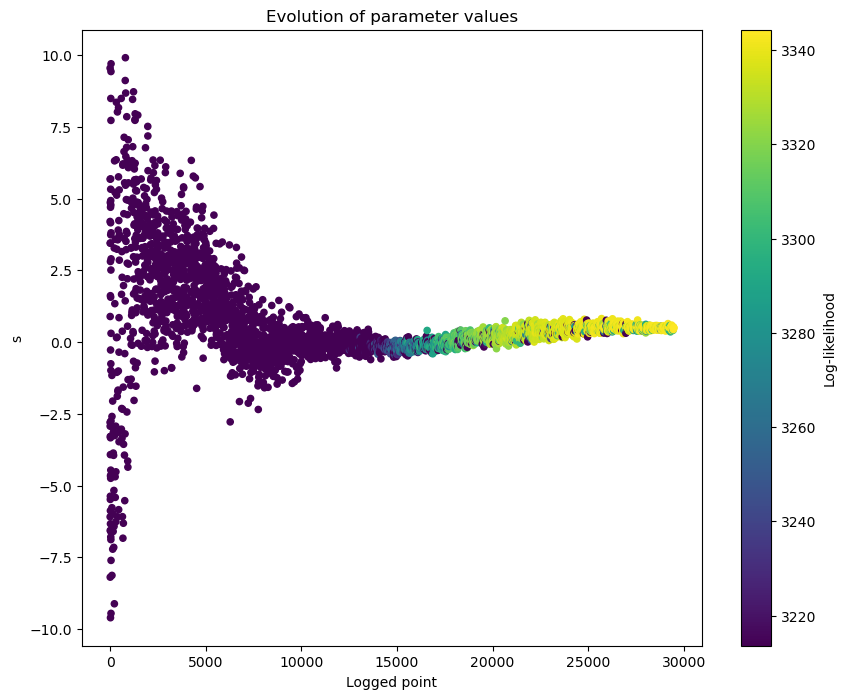

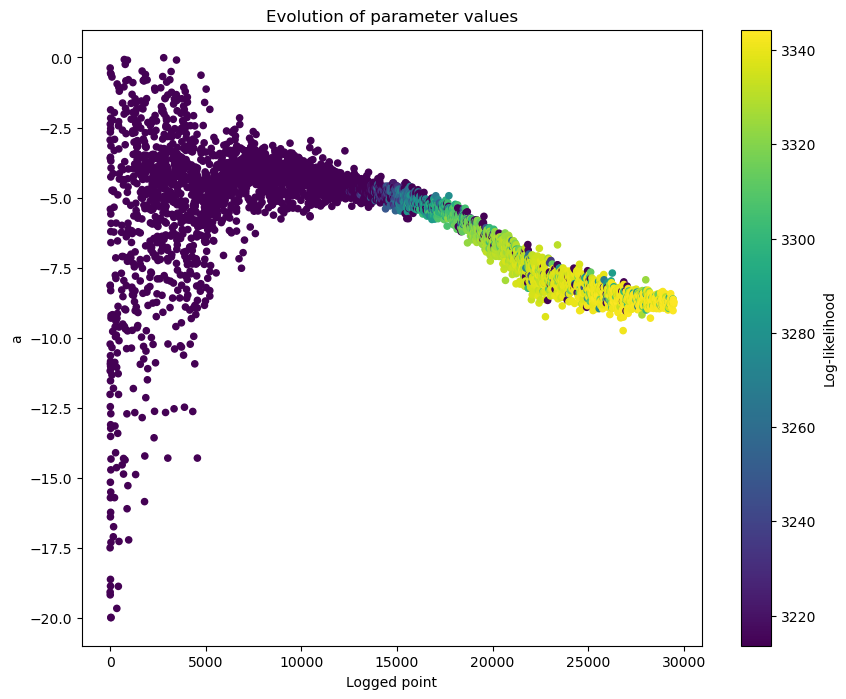

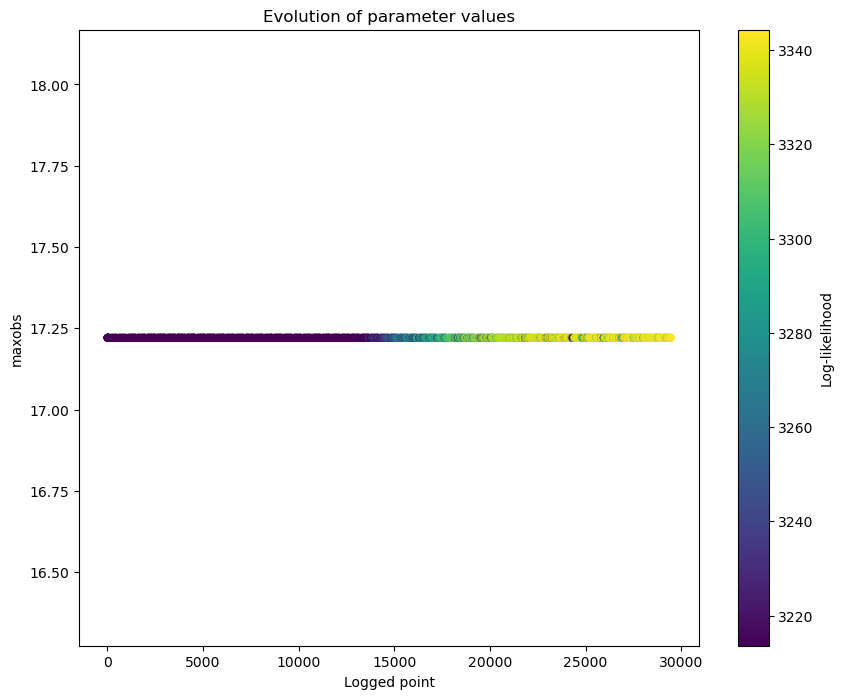

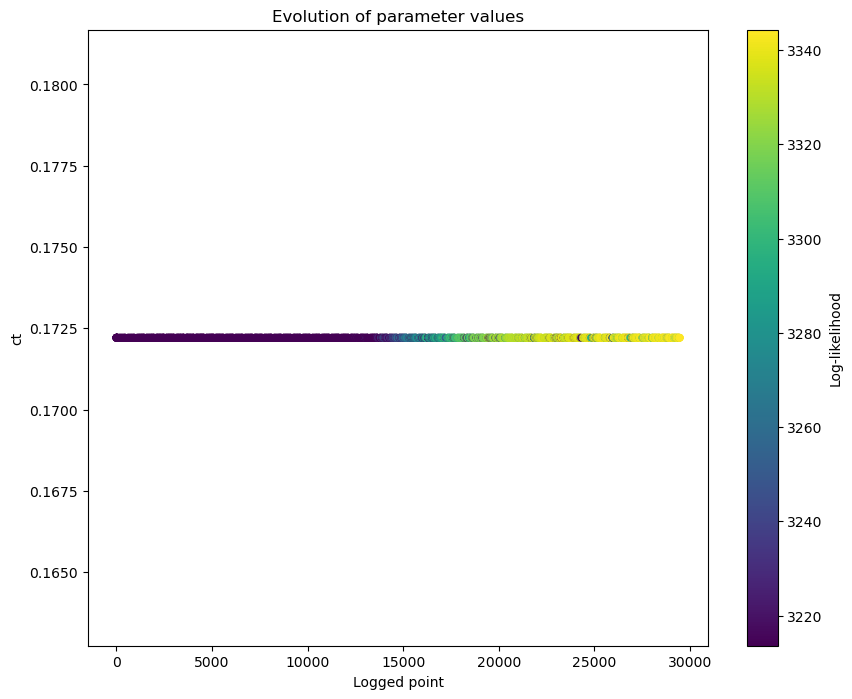

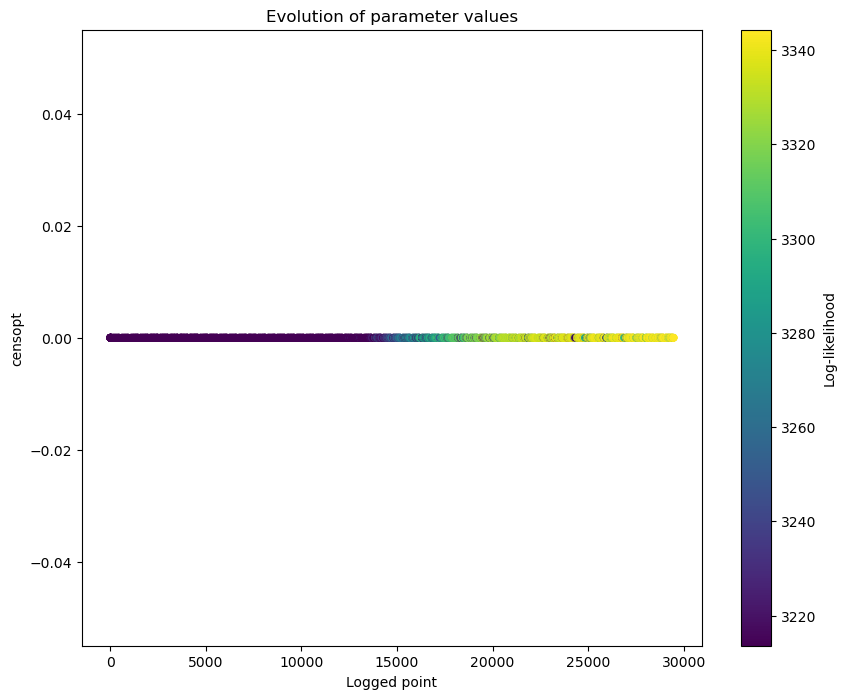

In [26]:
p_var_ids = p.as_dataframe().Name.values
v = OptimisationPlots(geom_ops)
for pVar in p_var_ids:
    g = v.parameter_evolution(pVar, obj_lims=[ll_min, ll_max])
    plt.gcf().set_size_inches(10,8)

Finally, get a visual of the runoff time series with the best known parameter set (the penultimate entry in the data frame with the log of the calibration process).

In [27]:
sortedResults = sort_by_score(calib_results, 'Log-likelihood')
sortedResults.as_dataframe().head().T

,0,1,2,3,4
Log-likelihood,3344.324148,3344.287835,3344.287237,3344.242922,3344.196302
subarea.Subarea.x1,141.896738,142.245467,141.955655,142.076460,142.086545
subarea.Subarea.x2,-29.998545,-29.999228,-29.995329,-29.993555,-29.989974
subarea.Subarea.x3,770.431535,770.246908,770.226682,770.161907,770.126385
subarea.Subarea.x4,1.000083,1.000617,1.000294,1.000565,1.000330
b,-1.110690,-1.126810,-1.146417,-1.130167,-1.101795
m,0.000000,0.000000,0.000000,0.000000,0.000000
s,0.452948,0.457996,0.488859,0.469665,0.438600
a,-8.767490,-8.892408,-8.778588,-8.732640,-8.678370
maxobs,17.221100,17.221100,17.221100,17.221100,17.221100


In [28]:
best_pset = calib_results.get_best_score('Log-likelihood').parameteriser
best_pset.apply_sys_config(ms)
ms.exec_simulation()
mod_runoff = ms.get_recorded(runoff_depth_varname)
# joki::plot_two_series(flow, mod_runoff, ylab="obs/mod runoff", startTime = start(flow), endTime = end(flow))

In [29]:
mod_runoff

<xarray.DataArray (variable_identifiers: 1, ensemble: 1, time: 5844)> Size: 47kB
array([[[0.        , 0.        , 0.        , ..., 0.41852807,
         0.4109582 , 0.40361163]]], shape=(1, 1, 5844))
Coordinates:
  * ensemble              (ensemble) int64 8B 0
  * time                  (time) datetime64[ns] 47kB 1990-01-01 ... 2005-12-31
  * variable_identifiers  (variable_identifiers) object 8B 'subarea.Subarea.r...

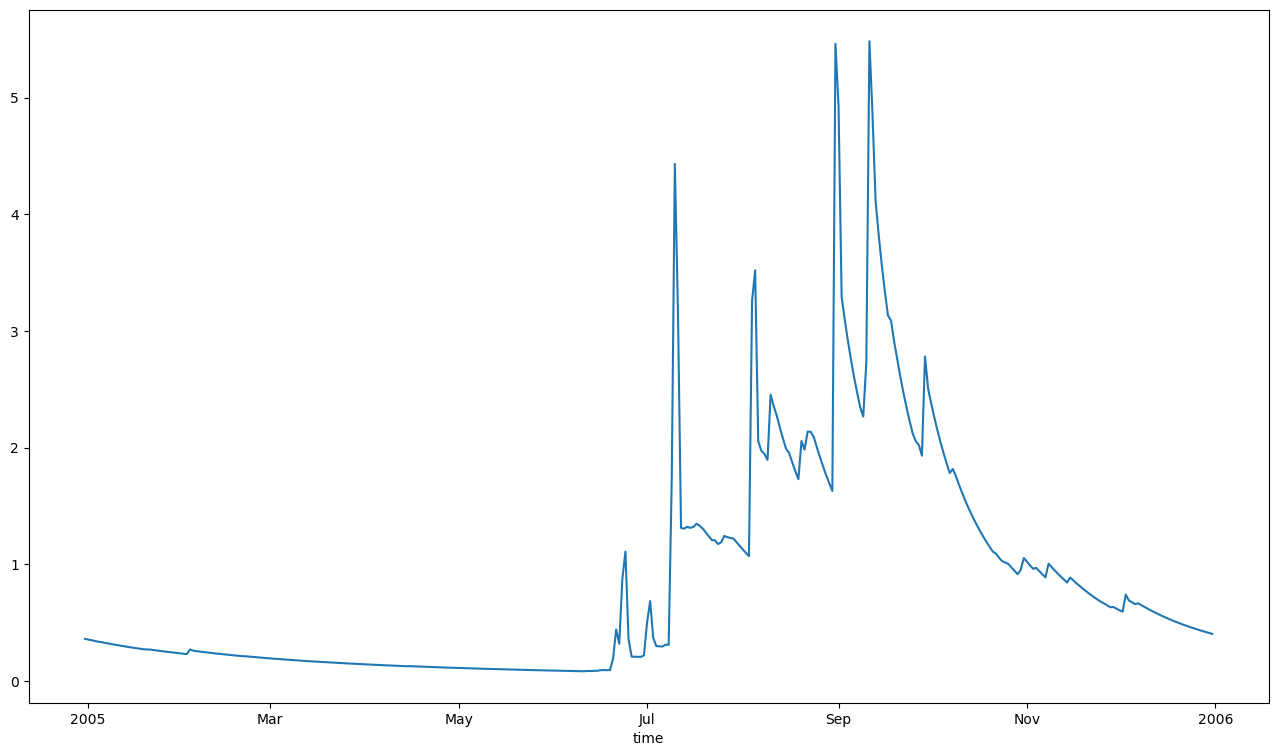

In [30]:
mod_runoff.squeeze(drop=True).sel(time=slice(e - pd.offsets.DateOffset(years=1), e)).plot(figsize=(16,9))

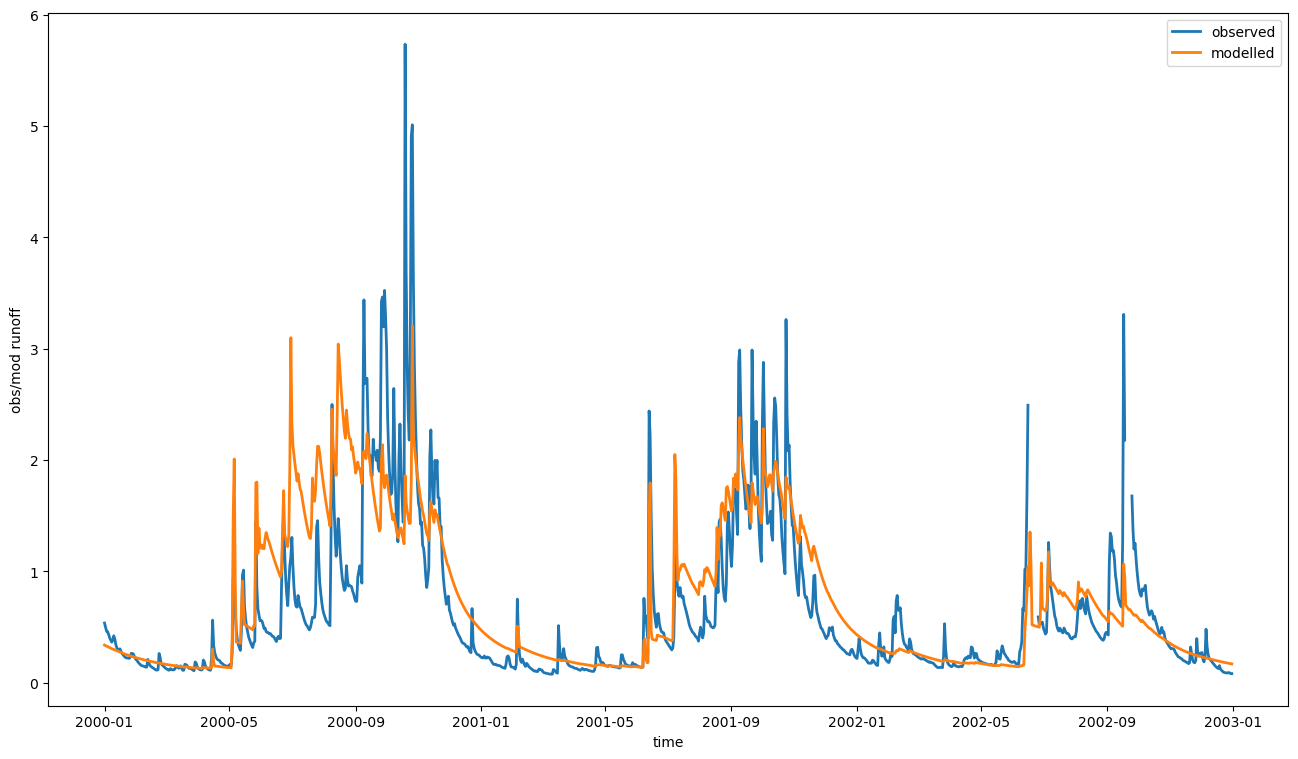

In [31]:
plot_two_series(flow, mod_runoff, ylab="obs/mod runoff", start_time = "2000-01-01", end_time = "2002-12-31", names=['observed','modelled'])